<h2 align="center" style="color:Green">Insurance Premium Estimator</h2>


- 1. Dependencies Installation and Imports
- 2. Data Loading
- 3. Data Exploration and Analysis
- 4. Data Preprocessing
- 5. Model Building
- 6. Model Evaluation
- 7. Model Optimization
- 8. Error Analysis

<h2 align="center" style="color:Green">Importing Required Dependencies</h2>

In [6]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


<h2 align="center" style="color:Green">Data Loading</h2>

In [7]:
df = pd.read_excel('premiums.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [9]:
df.shape

(50000, 13)

In [10]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [11]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

<h2 align="center" style="color:Green">Exploratory Data Analysis & Data Cleaning</h2>

### Handle Missing Values

In [12]:
# Checking for null values
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [13]:
# Dropping NA values as those are very less
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicates

In [14]:
# Handling Missing Values
df.duplicated().sum()

0

In [16]:
# if we update dataset and if we get any duplicate values, we drop before. For future proof
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

## 1. Numeric Columns

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

In [18]:

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [19]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

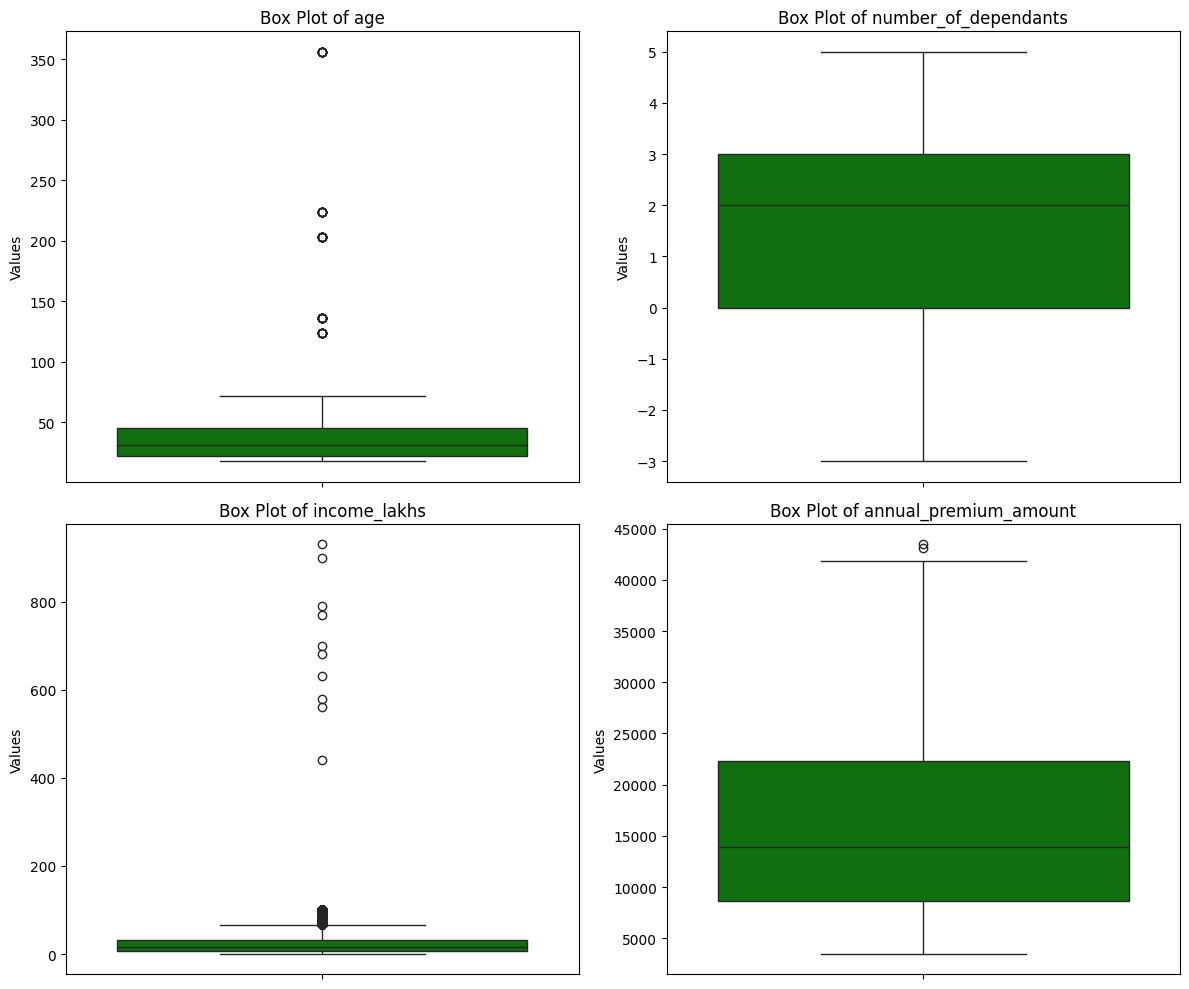

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, column in enumerate(numeric_columns):
    row = i // 2 
    col = i % 2
    sns.boxplot(ax=axes[row, col], data=df[column], color = 'green')
    axes[row, col].set_title(f'Box Plot of {column}')
    axes[row, col].set_ylabel('Values')

plt.tight_layout()
plt.show()

- Here we can see there are few outliers in age, number_of_dependants, income_lakhs. Now we can treat outliers

<h2 align="center" style="color:green">Data Preprocessing</h2>

#### Data Cleaning: number_of_dependants

In [23]:
df[df['number_of_dependants'] < 0]['number_of_dependants'].unique()

array([-3, -1])

In [25]:
df['number_of_dependants'] = df['number_of_dependants'].abs()
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.717284,23.021150,15766.810189
std,15.000378,1.491953,24.221794,8419.995271
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Outlier Treatment: Age Column

In [27]:
df[df['age']>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [30]:
df = df[df['age']<=100]
df[df['age']>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


### Outlier Treatment: Income Column

In [32]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df['income_lakhs'])
lower, upper


(-29.0, 67.0)

In [33]:
df[df.income_lakhs>upper].shape

(3559, 13)

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence after discussion with business we decided to use a simple quantile bound 

In [35]:
quantile_thresold = df.income_lakhs.quantile(0.999)
quantile_thresold

100.0

In [36]:
df[df.income_lakhs>quantile_thresold].shape

(10, 13)

In [38]:
df = df[df.income_lakhs<=quantile_thresold].copy()
df.shape

(49908, 13)

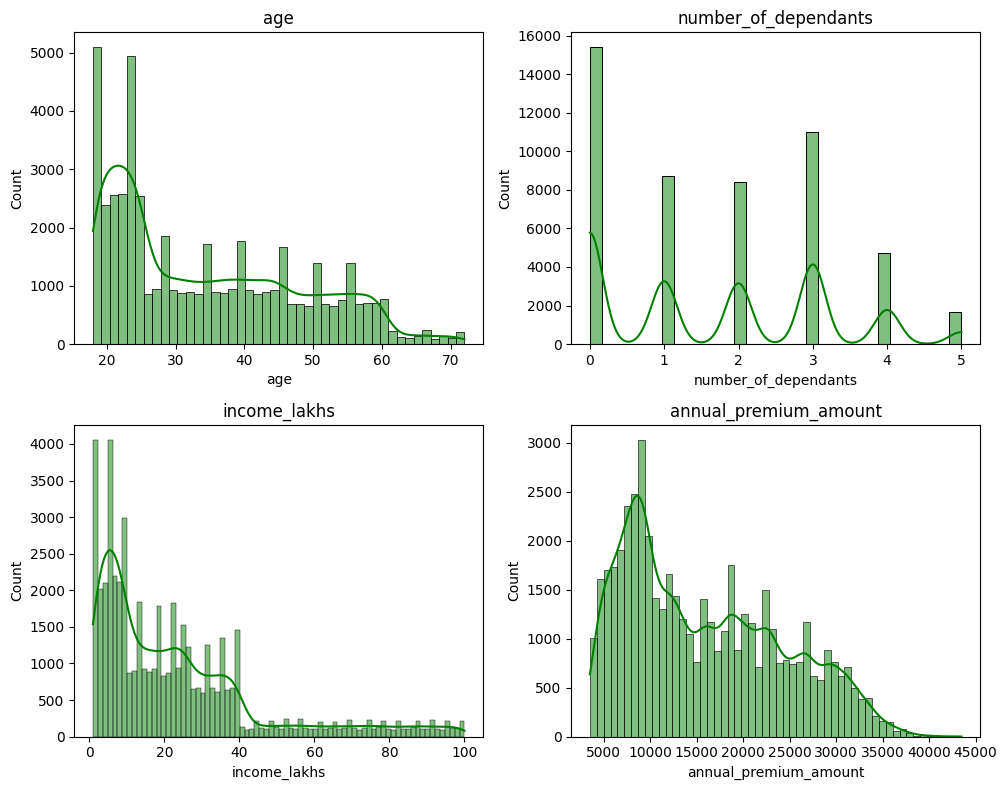

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]
    sns.histplot(df[column], kde=True, ax=ax, color = 'green')
    ax.set_title(column)

plt.tight_layout()
plt.show()

### Bivariate Analysis: Numeric Columns

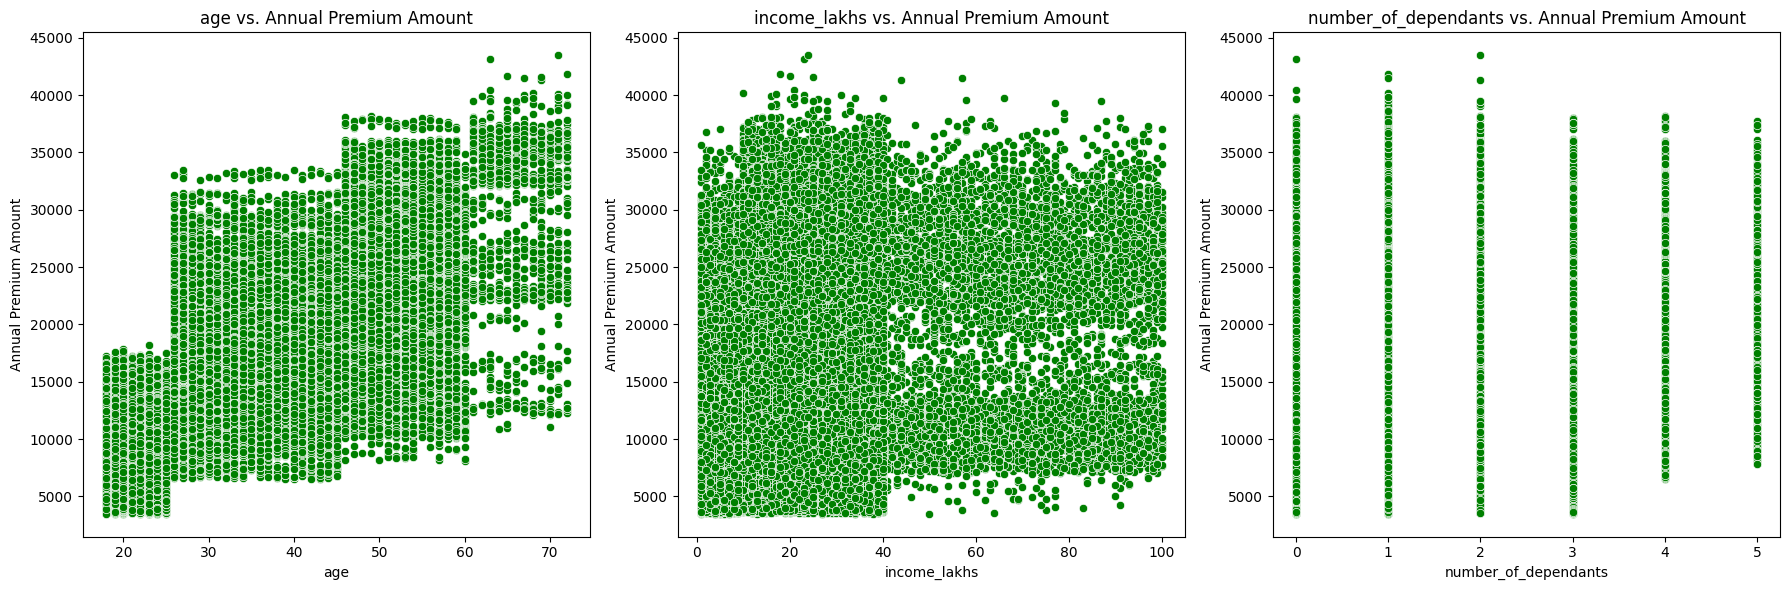

In [45]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df[column], y=df['annual_premium_amount'], ax=ax, color='green')
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

## 2. Categorical Columns

In [46]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [ ]:
df['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Univariate Analysis

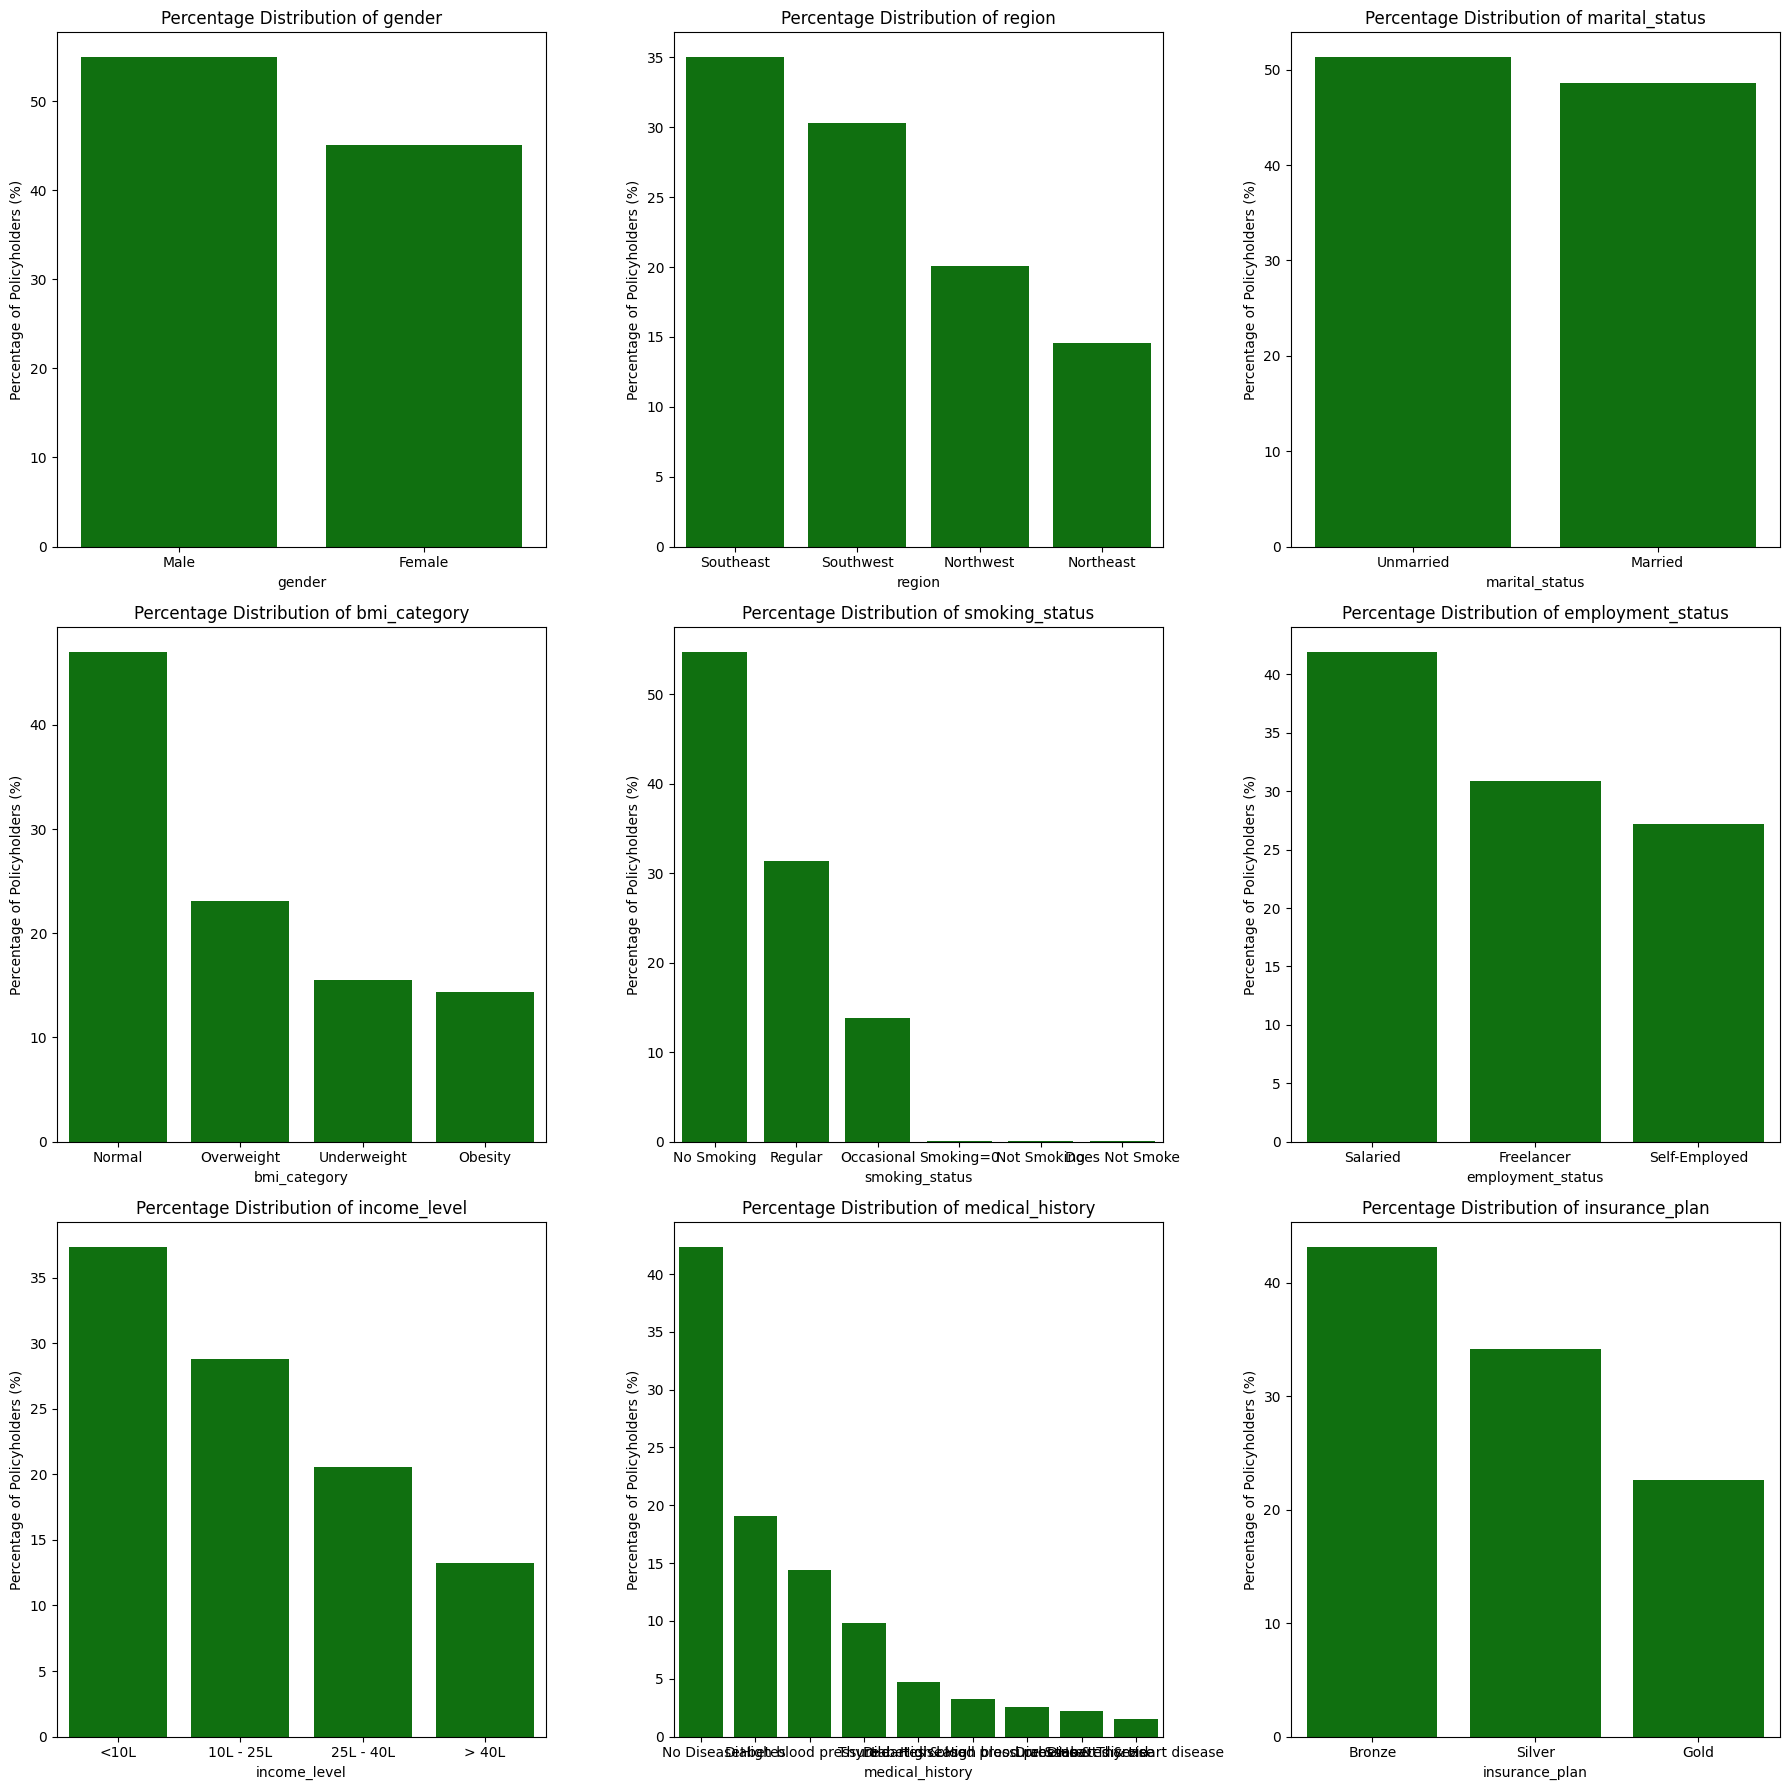

In [49]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, color = 'green')
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate Analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


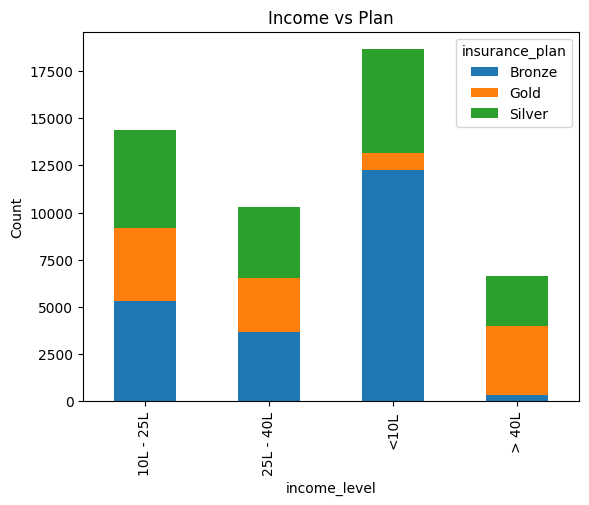

In [52]:
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

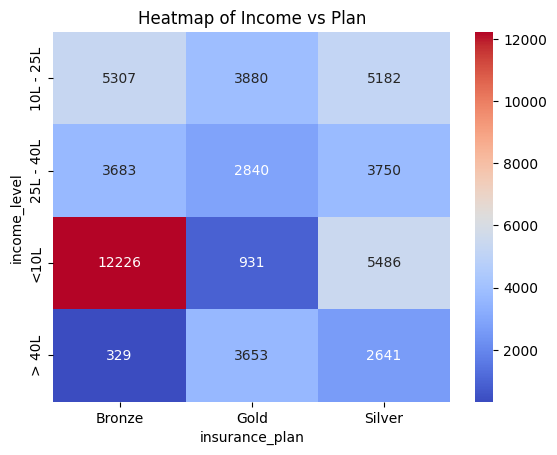

In [53]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center" style="color:green">Feature Engineering</h2>

### Calculate Risk Score

In [54]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df[['disease1', 'disease2']] = df['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df['disease1'].fillna('none', inplace=True)
df['disease2'].fillna('none', inplace=True)
df['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df['total_risk_score'] += df[disease].map(risk_scores)

max_score = df['total_risk_score'].max()
min_score = df['total_risk_score'].min()
df['normalized_risk_score'] = (df['total_risk_score'] - min_score) / (max_score - min_score)
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


### Encode Text Columns

In [58]:
df['insurance_plan'] = df['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [59]:
df['income_level'] = df['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [60]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)
df.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_No Smoking,smoking_status_Not Smoking,smoking_status_Occasional,smoking_status_Regular,smoking_status_Smoking=0,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,0.428571,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,0.428571,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49908 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              49908 non-null  int64  
 1   number_of_dependants             49908 non-null  int64  
 2   income_level                     49908 non-null  int64  
 3   income_lakhs                     49908 non-null  int64  
 4   medical_history                  49908 non-null  object 
 5   insurance_plan                   49908 non-null  int64  
 6   annual_premium_amount            49908 non-null  int64  
 7   disease1                         49908 non-null  object 
 8   disease2                         49908 non-null  object 
 9   total_risk_score                 49908 non-null  int64  
 10  normalized_risk_score            49908 non-null  float64
 11  gender_Male                      49908 non-null  int64  
 12  region_Northwest  

## Feature Selection

### Calculate VIF for Multicolinearity

In [63]:
df.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount',
       'disease1', 'disease2', 'total_risk_score', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_No Smoking', 'smoking_status_Not Smoking',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'smoking_status_Smoking=0', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

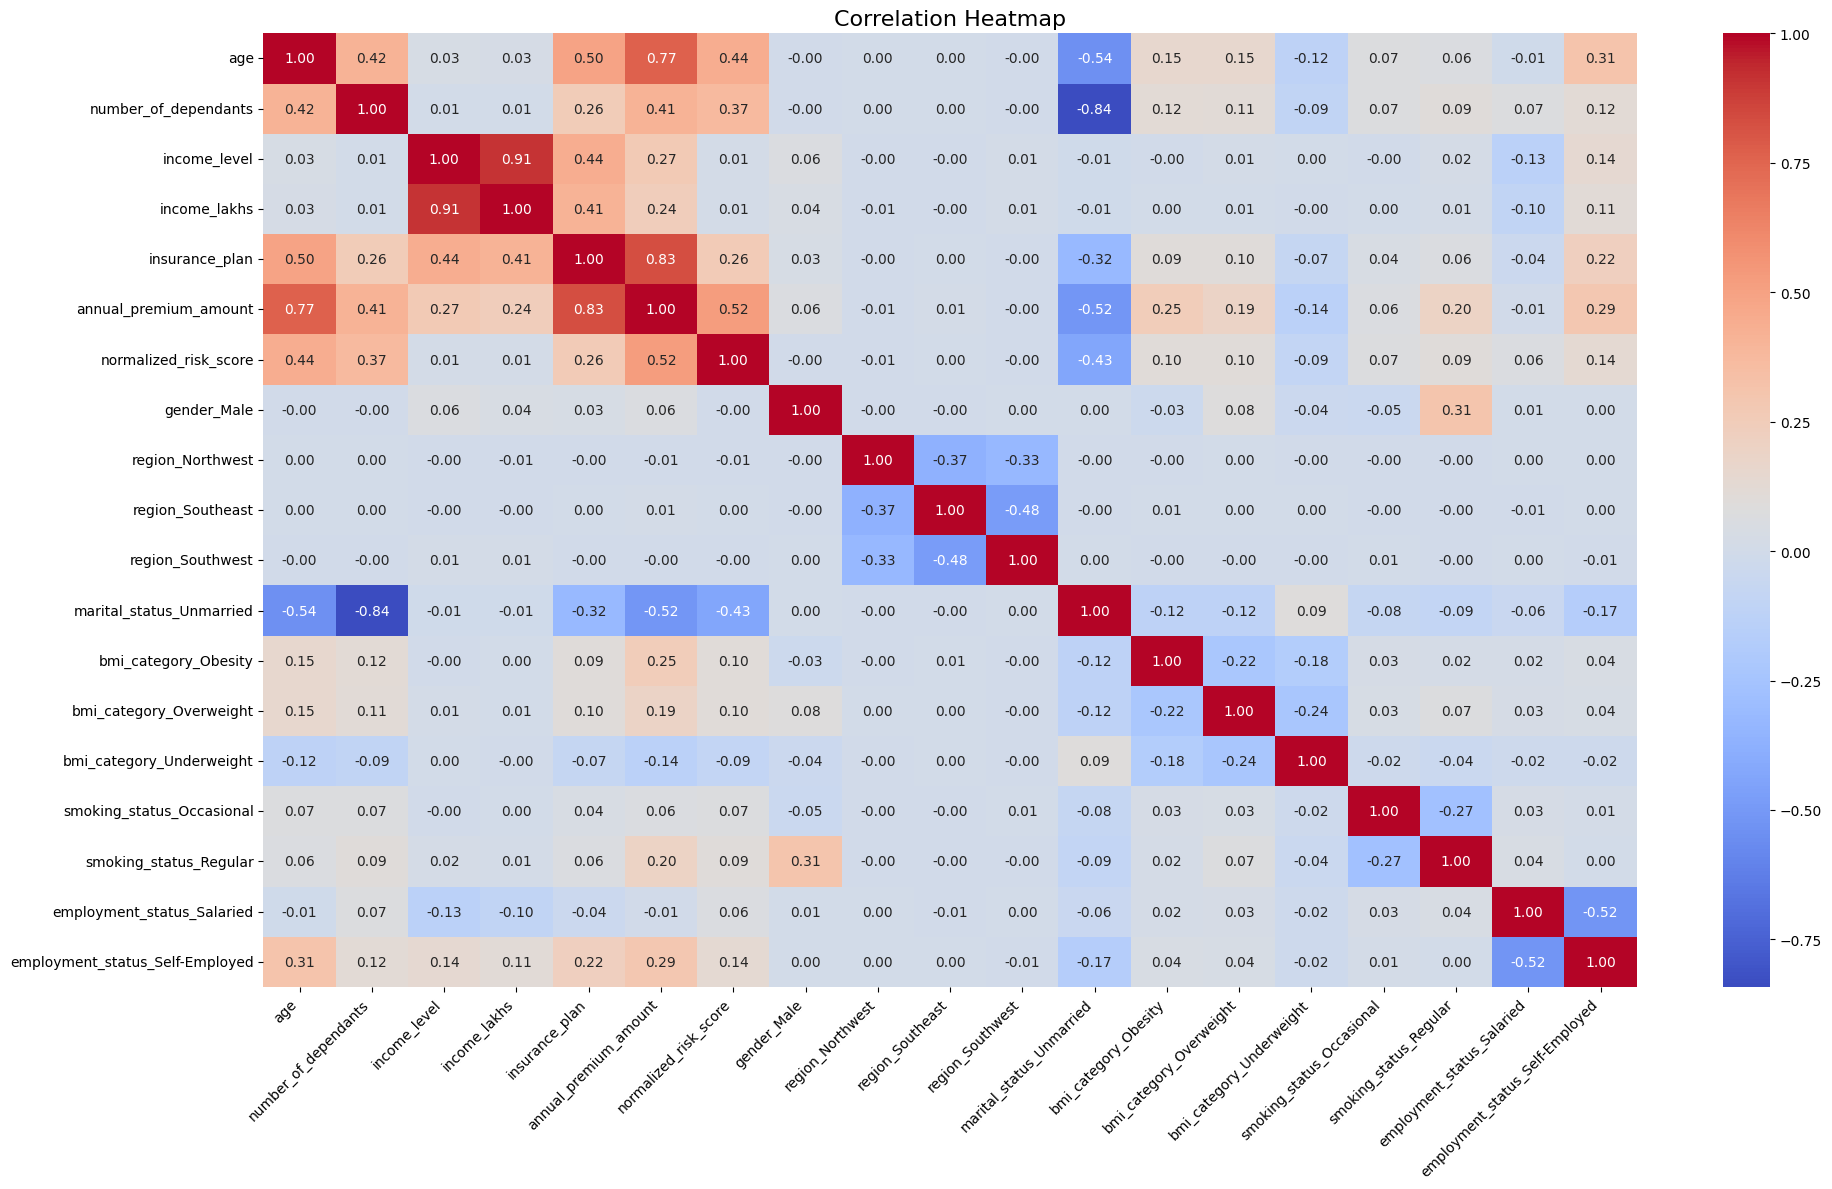

In [65]:
columns = [
    'age', 'number_of_dependants', 'income_level', 'income_lakhs',
    'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
    'gender_Male', 'region_Northwest', 'region_Southeast',
    'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
    'bmi_category_Overweight', 'bmi_category_Underweight',
    'smoking_status_Occasional', 'smoking_status_Regular',
    'employment_status_Salaried', 'employment_status_Self-Employed'
]

# Calculate the correlation matrix
correlation_matrix = df[columns].corr()

# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')  # Added color map and formatted float display
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

In [69]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your DataFrame with the relevant columns
columns_for_model = [
    'age', 'number_of_dependants', 'income_level', 'income_lakhs',
    'insurance_plan', 'normalized_risk_score',
    'gender_Male', 'region_Northwest', 'region_Southeast',
    'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
    'bmi_category_Overweight', 'bmi_category_Underweight',
    'smoking_status_Occasional', 'smoking_status_Regular',
    'employment_status_Salaried', 'employment_status_Self-Employed'
]

# Define features and target variable
X = df[columns_for_model].copy()  # Make a copy of the DataFrame to avoid SettingWithCopyWarning
y = df['annual_premium_amount']

# Define columns to scale
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Use .loc to safely modify the selected columns
X.loc[:, cols_to_scale] = scaler.fit_transform(X.loc[:, cols_to_scale])

# Get summary statistics of the transformed data
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [71]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [72]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [73]:
X_reduced = X.drop('income_level', axis="columns")

<h2 align="center" style="color:green">Model Training</h2>

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (34935, 17)
x test:  (14973, 17)
y train:  (34935,)
y test:  (14973,)


### Linear Regression Model

In [75]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9282143576916762, 0.9280547230217836)

In [76]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  5165611.9130279925 RMSE:  2272.7982561212934


In [77]:
X_test.shape

(14973, 17)

In [78]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([11160.926462,  -676.443991,  -514.229816, 12557.012936,
        4810.357702,   168.646662,   -35.719292,    39.96513 ,
         -24.652929,  -935.760611,  3387.911455,  1599.362268,
         391.171304,   735.912278,  2234.804712,   155.984674,
         415.903973])

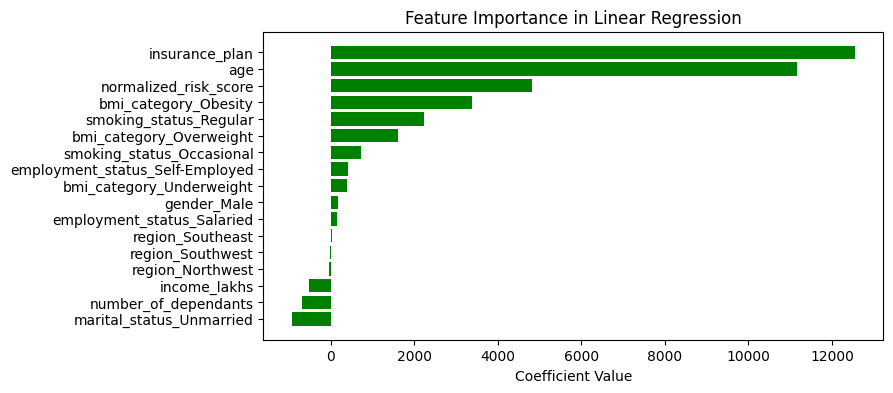

In [109]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='green')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [80]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9282143198366275, 0.9280541644640345)

In [81]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  5165652.017016523 RMSE:  2272.8070787060924


### XGBoost 

In [87]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9782300591468811

In [88]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  1563064.0 RMSE:  1250.2255796455295


In [89]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9809474547704061

In [90]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [92]:
best_model = random_search.best_estimator_

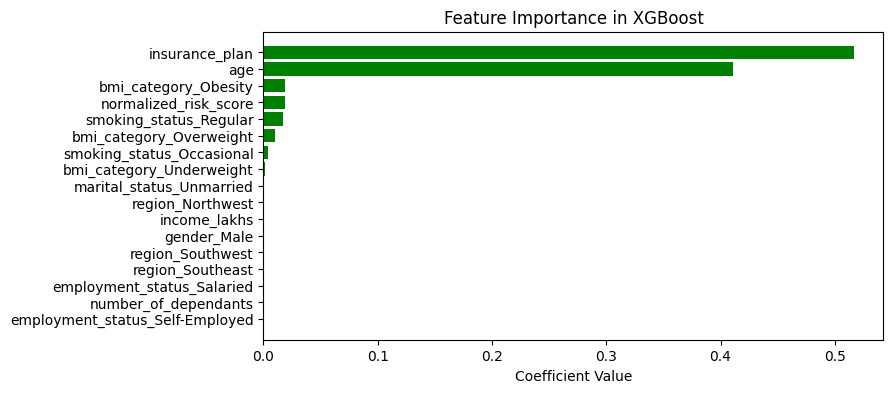

In [110]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='green')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

<h2 align="center" style="color:green">Error Analysis</h2>

In [94]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


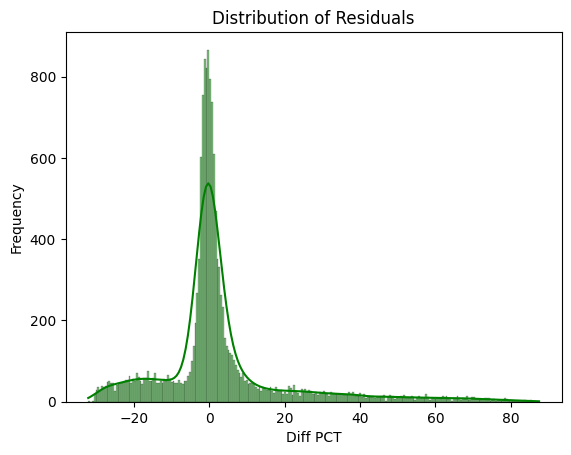

In [111]:
sns.histplot(results_df['diff_pct'], kde=True, color = 'green')
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [96]:
X_test.shape

(14973, 17)

In [97]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
42730,5018,7352.829590,2334.829590,46.529087
20029,5140,6670.849121,1530.849121,29.783057
4294,9631,7053.477539,-2577.522461,-26.762771
44419,4687,6670.849121,1983.849121,42.326629
6707,8826,10047.326172,1221.326172,13.837822


In [98]:
extreme_results_df.shape

(4487, 4)

In [99]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

29.967274427302478

In [100]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
36269,3501,6565.852051,3064.852051,87.542189
48801,3516,6565.852051,3049.852051,86.742095
42342,3521,6565.852051,3044.852051,86.476911
18564,3523,6565.852051,3042.852051,86.371049
7988,3527,6565.852051,3038.852051,86.159684
...,...,...,...,...
32671,4656,6994.980957,2338.980957,50.235845
14798,4371,6565.852051,2194.852051,50.213957
13736,4371,6565.852051,2194.852051,50.213957
10107,4710,7073.240723,2363.240723,50.174962


In [101]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0


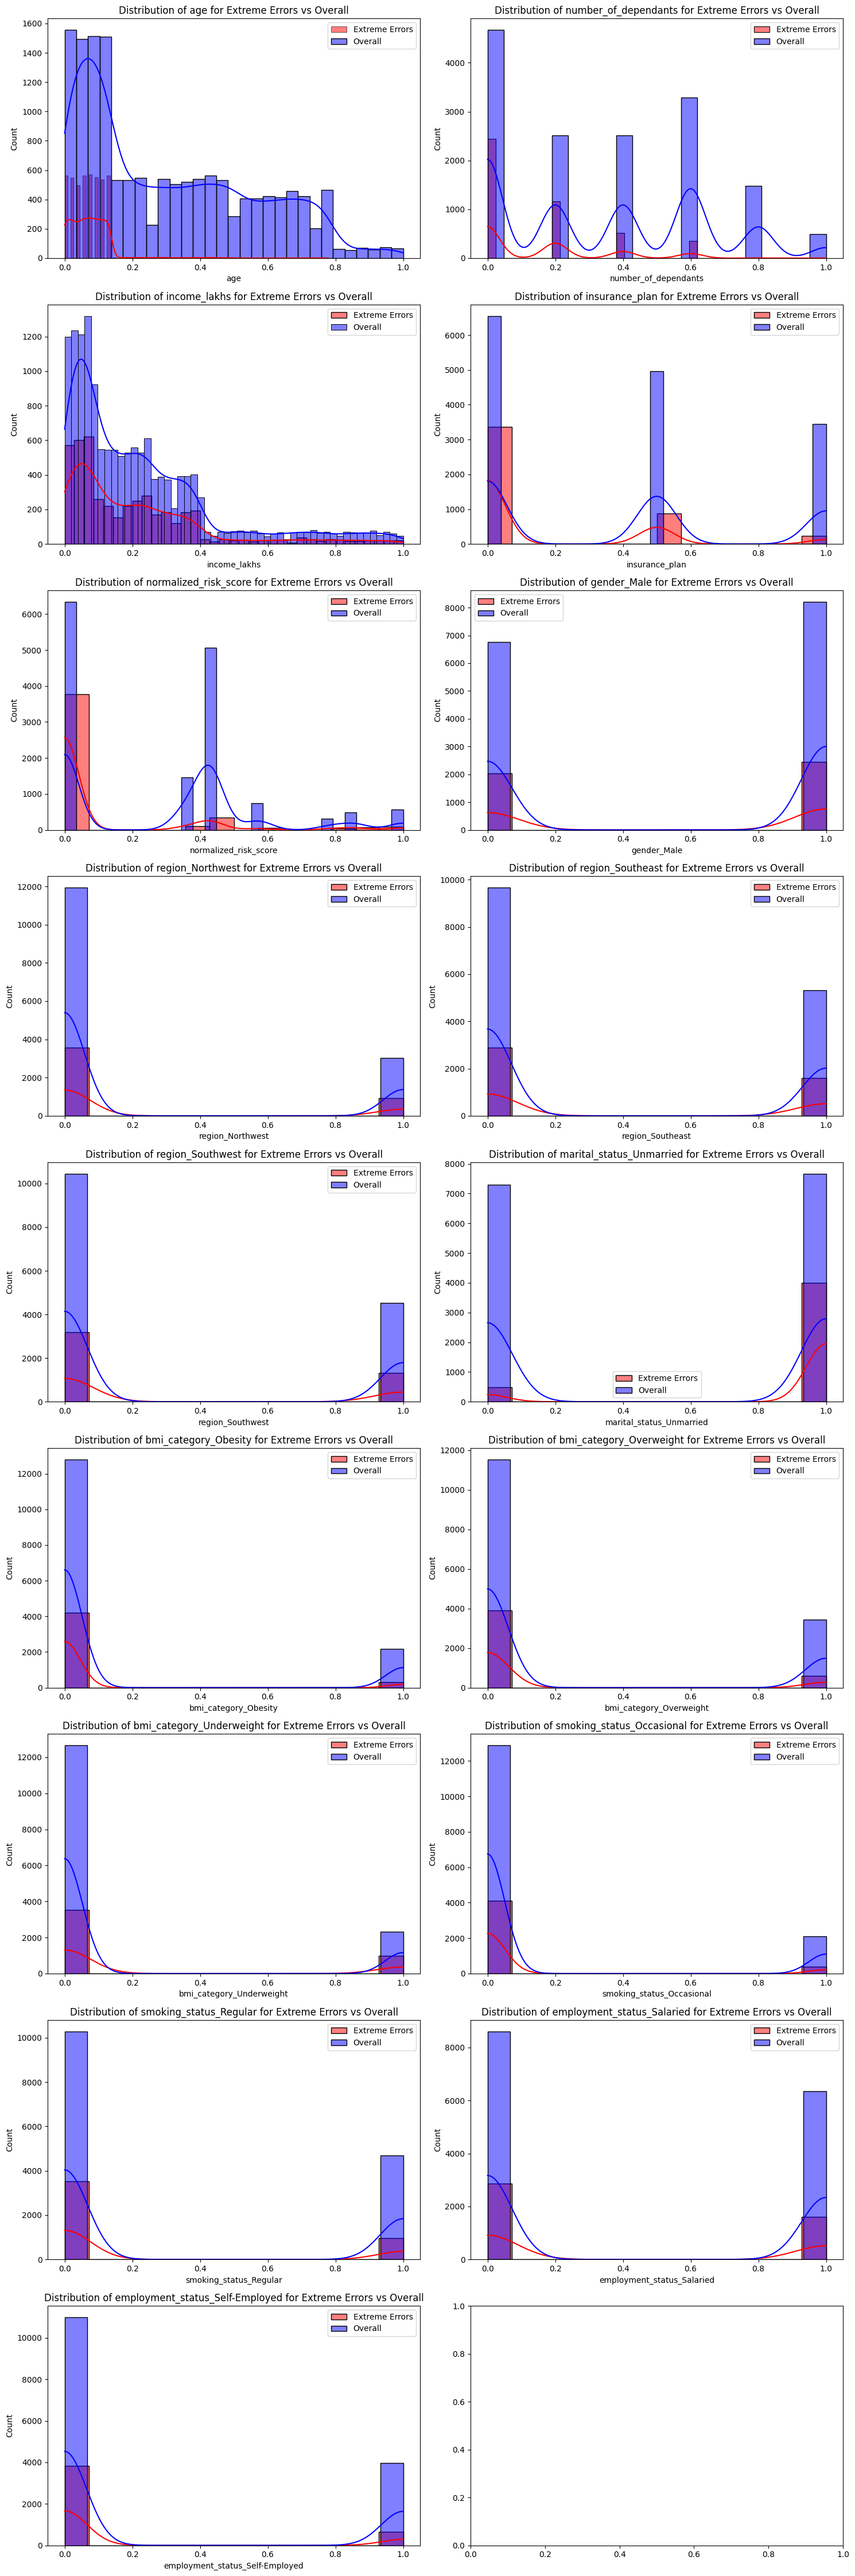

In [102]:
n_features = len(X_test.columns)

# Number of rows needed for subplots (2 charts per row)
n_rows = (n_features + 1) // 2  # Ceiling division to get the correct number of rows

# Create subplots with 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

# Flatten axes for easier indexing
axes = axes.flatten()

# Loop through features and create a plot for each
for i, feature in enumerate(X_test.columns):
    ax = axes[i]
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True, ax=ax)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True, ax=ax)
    ax.legend()
    ax.set_title(f'Distribution of {feature} for Extreme Errors vs Overall')

# Adjust layout
plt.tight_layout()
plt.show()

In [104]:
extreme_errors_df['income_level']=-1

In [105]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0


### Reverse Scaling

In [106]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4487.000000,4487.000000,4487.0,4487.000000,4487.000000
mean,21.804992,0.739247,-2.0,21.182527,1.302429
std,3.172355,0.968855,0.0,20.598596,0.563135
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,5.000000,-2.0,100.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

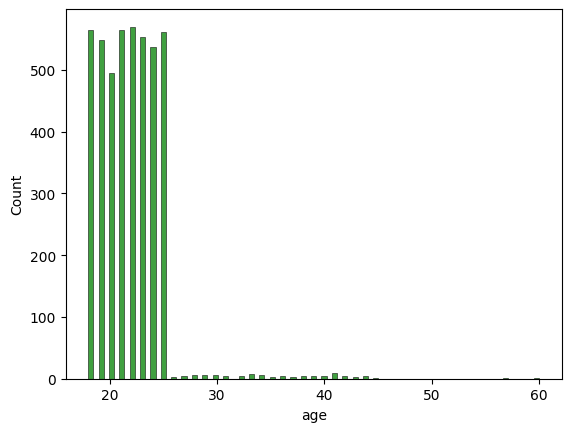

In [112]:
sns.histplot(df_reversed.age, color = 'green')

This shows that majority of the extreme errors are coming from young age group (i.e. <25 years of age). We need to may be build a separate model for this segment